# Lab. 7 - Variable selection

In this lab we will move to considering the problems of variable selection in classification (thus supervised) scenarios.

As usual, we start importing libraries and functions already used in one of the previous labs.

In [1]:
# import libraries
%matplotlib inline
# Andres  Coronado  2761046
# Giacomo Garbarino 4545532
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy.linalg as la

### Data generation

To generate a synthetic dataset suitable for use with variable selection, we first generate a subset of "relevant" features, and then concatenate with a second set of "dummy", irrelevant featuers. To this purpose,  we proceed as follows:
- Generate a dataset with the `mixGauss` function: use two Gaussians which are *close* with each other (see example below). Start by considering 2-Dimensional points
- Plot the points: you should observe two point-clouds which mix with each other (since they were generated with the same parameters).
- Enrich the input samples with "dummy" features randomly sampled and concatenate to the relevant features (notice that at this point data visualization is no more possible


In [2]:
def mixGauss(means, sigmas, n):

    means = np.array(means)
    sigmas = np.array(sigmas)

    d = means.shape[1]
    num_classes = sigmas.size
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes)

    for idx, sigma in enumerate(sigmas):
        data[idx * n:(idx + 1) * n] = np.random.multivariate_normal(
            mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2, size=n)
        labels[idx * n:(idx + 1) * n] = idx 
        
    if(num_classes == 2):
        labels[labels==0] = -1

    return data, labels

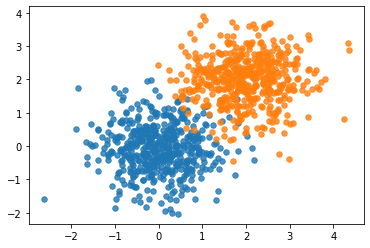

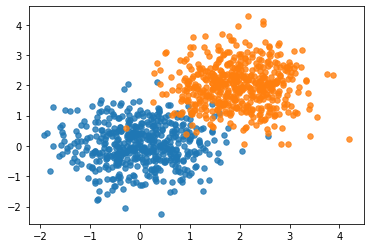

In [3]:
n=500 # number of features for each gaussian
d=30 # total number of features
d_rev = 2 # number of relevant features

Xtr, Ytr = mixGauss(means = [[0,0],[2,2]], sigmas = [0.7, 0.7], n=n)
Xte, Yte = mixGauss(means = [[0,0],[2,2]], sigmas = [0.7, 0.7], n=n)

# plot
plt.figure()
plt.scatter(Xtr[Ytr==-1,0], Xtr[Ytr==-1,1], s=30, alpha=0.80)
plt.scatter(Xtr[Ytr==1,0], Xtr[Ytr==1,1], s=30, alpha=0.80)
plt.figure()
plt.scatter(Xte[Yte==-1,0], Xte[Yte==-1,1], s=30, alpha=0.80)
plt.scatter(Xte[Yte==1,0], Xte[Yte==1,1], s=30, alpha=0.80)


# dummy features generation
sigma_noise = 0.01
Xtr_noise = sigma_noise * np.random.randn(2*n, d-d_rev)
Xtr = np.concatenate((Xtr,Xtr_noise), axis=1)
Xte_noise = sigma_noise * np.random.randn(2*n, d-d_rev)
Xte = np.concatenate((Xte,Xte_noise), axis=1)

In [4]:
Xtr.shape

(1000, 30)

## Variable selection

##### OMatchingPursuit

It computes a sparse representation of the signal using Orthogonal Matching Pursuit algorithm. Use it as follows:
    
`w, r, I = OMatchingPursuit( X, Y, T)`

where
    - X: input data
    - Y: output labels
    - T: number of iterations
    - w: estimated coefficients
    - r: residuals
    - I: indices


In [5]:
def OMatchingPursuit(X, Y, T):

    N, D = np.shape(X)

    # 1. Initialization of residual, coefficient vector and index set I
    r = Y
    w = np.zeros(D)
    I = []

    for i in range(T):
        I_tmp = range(D)

        # 2. Select the column of X which coefficients most "explains" the residual
        a_max = -1

        for j in I_tmp:
            a_tmp = ((r.T.dot(X[:, j])) ** 2) / (X[:, j].T.dot(X[:, j]))

            if a_tmp > a_max:
                a_max = a_tmp
                j_max = j

        # 3. Add the index to the set of indexes
        if np.sum(I == j_max) == 0:
            I.append(j_max)

        # Compute the M matrix
        M_I = np.zeros((D, D))

        for j in I:
            M_I[j, j] = 1

        A = M_I.dot(X.T).dot(X).dot(M_I)
        B = M_I.dot(X.T).dot(Y)

        # 4. Update estimated coefficients
        w = la.pinv(A).dot(B)

        # 5. Update the residual
        r = Y - X.dot(w)

    return w, r, I

In [6]:
# Usual function to compute the error in predicted labels (for a binary classification problem)
def calcError(Ypred, Y):

    V=np.multiply(np.sign(Ypred),np.sign(Y) )
    return np.count_nonzero(V<0)/len(Y)

In [7]:
# K-Fold Cross Validation for selecting the best value for the hyperparameters in the use of 
# Orthogonal Matching Pursuit (we refer to the number of iterations)

def KFoldCVOMP(Xtr, Ytr, KF, niter_list):

    if KF <= 0:
        print("Please supply a positive number of repetitions")
        return -1

    # Ensures that k_list is a numpy array
    niter_list = np.array(niter_list)
    num_niter = niter_list.size

    n_tot = Xtr.shape[0]
    n_val = int(np.floor(n_tot/KF))

    Tm = np.zeros(num_niter)
    Ts = np.zeros(num_niter)
    Vm = np.zeros(num_niter)
    Vs = np.zeros(num_niter)

    # Random permutation of training data
    rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
    
    
    for kdx, niter in enumerate(niter_list):
        first = 0
        for fold in range(KF):
            flags = np.zeros(Xtr.shape[0])
            flags[first:first+n_val]=1;
            
            X = Xtr[rand_idx[flags==0]]
            Y = Ytr[rand_idx[flags==0]]
            X_val = Xtr[rand_idx[flags==1]]
            Y_val = Ytr[rand_idx[flags==1]]

            # Compute the training error of OMP for the given number of iterations
            w, r, I = OMatchingPursuit(X, Y, niter)
            YpredTR = np.sign(X.dot(w))
            trError = calcError(YpredTR, Y)
            Tm[kdx] = Tm[kdx] + trError
            Ts[kdx] = Ts[kdx] + trError ** 2

            # Compute the validation error OMP for the given number of iterations
            YpredVAL = np.sign(X_val.dot(w))
            valError = calcError(YpredVAL, Y_val)
            Vm[kdx] = Vm[kdx] + valError
            Vs[kdx] = Vs[kdx] + valError ** 2
            
            first = first+n_val                

    Tm = Tm / KF
    Ts = Ts / KF - Tm ** 2

    Vm = Vm / KF
    Vs = Vs / KF - Vm ** 2

    best_niter_idx = np.argmin(Vm)
    bestniter = niter_list[best_niter_idx]
    
    print("Validation error: ",Vm)
    print("Number of iteration list: ",niter_list)
    print("Best number of iterations index: ",best_niter_idx)

    return bestniter, Vm, Vs, Tm, Ts

### Some analysis

We suggest to proceed as follows:

- Standardize the data
- Run Orthogonal Matching Pursuit on the training set setting a reasonable number of iterations
- Compute the prediction on the test set and evaluate the error
- Plot the components of the solution w (considering their absolute value): how do they look?
- Run the K-Fold Cross Validation to select an appropriate value for the number of iterations

**Please write your comments on the solution in a new cell in this notebook.**

**Make sure that all relevant plots are visible when you submit the notebook!**

I:  [1, 0, 29, 5, 26, 25, 8, 19, 22, 16]
w[I]:  [0.49362056 0.48476321 0.0331563  0.02932072 0.02917989 0.02629365
 0.02503488 0.02002746 0.0194487  0.01596276]
Test error: 2.00%


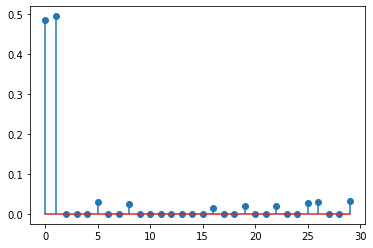

In [8]:
# Data standardization
m = np.mean(Xtr, axis=0)
s = np.std(Xtr, axis=0)
Xtrnorm = np.divide((Xtr-m), s)
Xtenorm = np.divide((Xte-m), s)

# Run Orthogonal Matching Pursuit
w, r, I = OMatchingPursuit(Xtrnorm, Ytr, T=10)
print("I: ", I)
print("w[I]: ", abs(w[I]))
# Compute the prediction on the test set
Ypred = np.dot(Xtenorm,w)

# Compute the test error and show its value
ts_err = calcError(Ypred, Yte)
print(f"Test error: {ts_err*100:.2f}%")

# Plot the components of the solution w
plt.stem(abs(w), use_line_collection=True)
plt.show()

Validation error:  [0.261 0.244 0.247 0.25  0.252 0.25  0.243 0.255 0.253 0.245 0.247 0.248
 0.254 0.246 0.246 0.248 0.247 0.249 0.245 0.248 0.241 0.243 0.245 0.244
 0.244 0.243 0.243 0.243 0.242]
Number of iteration list:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Best number of iterations index:  20
Best number of iterations: 21


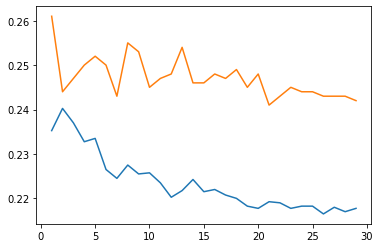

In [9]:
# Define an appropriate range of possible iterations number and run K-Fold Cross Validation
KF = 5
niter_list = np.arange(1,30)
bestniter, Vm, Vs, Tm, Ts = KFoldCVOMP(Xtr, Ytr, KF, niter_list)

# Plot training and validation error
plt.subplots()
plt.plot(niter_list, Tm)
plt.plot(niter_list, Vm)
print('Best number of iterations: '+str(bestniter))

### Conclusions
The test error using 10 iterations is equal to 2.00%. The stem plot of *w* shows that the most two relevant variables are in position 0 and 1 because the corresponding values of *w* are much higher than the other ones. Running K-Fold Cross Validation with *K=5*, the best number of iterations is equal to 21, so in this case 10 iterations are quite far from the best ones.